## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [35]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import warnings 
warnings.filterwarnings('ignore')
# __________end of block__________

In [3]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [28]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [5]:
CUDA_DEVICE_ID = 0  # change if needed

In [6]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

In [7]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    # Нормализуем данные – это может помочь оптимизации
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


Text(0.5, 1.0, 'Image label: 6')

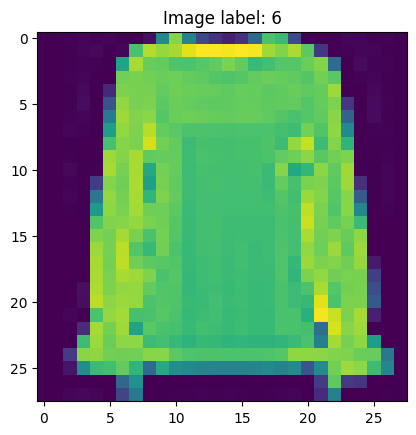

In [8]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [35]:
'''class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Первый сверточный блок: увеличиваем число каналов до 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        
        # Второй сверточный блок: 64 -> 128 каналов
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        
        # Третий сверточный блок: 128 -> 256 каналов
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        
        # Слои Dropout для регуляризации
        self.dropout_conv = nn.Dropout(0.3)
        
        # Вычисляем размер выхода после сверточных блоков.
        # После двух пуллингов (каждый сокращает размер в 2 раза): 28x28 → 14x14 → 7x7.
        self.fc1   = nn.Linear(256 * 7 * 7, 256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2   = nn.Linear(256, 10)

    def forward(self, x):
        # x имеет форму (batch_size, 1, 28, 28)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        # Без дополнительного пула – размер уже 7x7
        x = x.view(x.size(0), -1)  # преобразуем в вектор
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        logits = self.fc2(x)
        return logits'''
    


'''class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)  # первый полносвязный слой
        self.fc2 = nn.Linear(256, 128)      # второй полносвязный слой
        self.fc3 = nn.Linear(128, 10)       # выходной слой

    def forward(self, x):
        # x имеет форму (batch_size, 1, 28, 28)
        x = x.view(x.size(0), -1)  # преобразуем в (batch_size, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)  # возвращаются логиты для 10 классов
        return logits'''

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Первый сверточный блок: Conv -> BatchNorm -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Второй сверточный блок: Conv -> BatchNorm -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Полносвязные слои для классификации
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # после двух пулов размер 28x28 -> 7x7
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x имеет форму (batch_size, 1, 28, 28)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # разворачиваем в вектор
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits


# Creating model instance
model_task_1 = Discriminator()
print(model_task_1)

Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Не забудьте перенести модель на выбранный `device`!

In [36]:
model_task_1.to(device)

Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [37]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

data = []
y = []

for image, label in train_fmnist_data:
    data.append(np.ravel(image))
    y.append(label)

    
data = np.array(data)
y = np.array(y)

ss = StandardScaler().fit(data)
pca = PCA(n_components=200).fit(data)
data = ss.transform(data)
data_pca = pca.transform(data)

data_pca
test_data = []
test_y = []

for image, label in test_fmnist_data:
    test_data.append(np.ravel(image))
    test_y.append(label)
    
test_data = np.array(test_data)
test_y = np.array(test_y)
test_data = ss.transform(test_data)
test_data_pca = pca.transform(test_data)



model = LogisticRegression()
model.fit(data_pca,y)

print(model.score(test_data_pca,test_y.reshape(-1,1)))
print(accuracy_score(test_y.reshape(-1,1),model.predict(test_data_pca)))

0.8426
0.8426


In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_task_1.parameters(), lr=0.001)

num_epochs = 20  # можно увеличить число эпох для повышения качества

for epoch in tqdm(range(num_epochs)):
    model_task_1.train()  # переводим модель в режим обучения
    running_loss = 0.0
    for images, labels in train_data_loader:
        # Переносим входные данные на устройство
        images, labels = images.to(device), labels.to(device)
        
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model_task_1(images)
        loss = criterion(outputs, labels)
        
        # Обратное распространение ошибки и оптимизация
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.4111
Epoch [2/20], Loss: 0.2849
Epoch [3/20], Loss: 0.2442
Epoch [4/20], Loss: 0.2192


KeyboardInterrupt: 

In [ ]:
'''optimizer = torch.optim.AdamW(model_task_1.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

num_epochs = 20  # увеличиваем число эпох для лучшего обучения

for epoch in tqdm(range(num_epochs),'Epoch'):
    model_task_1.train()
    running_loss = 0.0
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_task_1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    scheduler.step()  # корректируем learning rate
    avg_loss = running_loss / len(train_data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")'''

'optimizer = torch.optim.AdamW(model_task_1.parameters(), lr=0.001, weight_decay=1e-4)\nscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)\ncriterion = nn.CrossEntropyLoss()\n\nnum_epochs = 20  # увеличиваем число эпох для лучшего обучения\n\nfor epoch in tqdm(range(num_epochs),\'Epoch\'):\n    model_task_1.train()\n    running_loss = 0.0\n    for images, labels in train_data_loader:\n        images, labels = images.to(device), labels.to(device)\n        optimizer.zero_grad()\n        outputs = model_task_1(images)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n        \n    scheduler.step()  # корректируем learning rate\n    avg_loss = running_loss / len(train_data_loader)\n    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")'

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [ ]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.94202


In [ ]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8889


Проверка, что необходимые пороги пройдены:

In [ ]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [22]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!